In [ ]:
import os
import string
import requests
from bs4 import BeautifulSoup
import nltk
import cPickle as pickle
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [22]:
# xkcd mode isn't compatible with TeX mode, so turn it off, just in case
from matplotlib import rc
rc('text', **{'usetex': False})

In [ ]:
def classify():
    """
    Read in the corpus, remove punctuation, and convert it all to lowercase
    This is slightly slower than reading the entire file into memory
    but it's more memory-efficient by far
    We want to keep the dash/minus, since en and em aren't used in the text

    """
    punc = [char for char in string.punctuation]
    punc.remove('-')
    punc.remove('.')
    # don't do this in production, because race conditions and security and that
    if not os.path.isfile('results.pickle'):
        cleanup = []
        soup = BeautifulSoup(
            requests.get("http://gutenberg.net.au/ebooks06/0600031h.html").text)
        # leading and trailing paras don't contain anything useful
        # translate() is a pain with Unicode
        text = tuple(
            sec.get_text().encode('utf8') for sec in soup.find_all('p')[4:-5])
        for line in text:
            inp = line.translate(None, ''.join(punc)).lower().decode('utf8')
            for sent in nltk.sent_tokenize(inp):
                tagged = nltk.pos_tag(nltk.word_tokenize(sent))
                cleanup.append(tagged)
        # classification is time-consuming. Let's save our results
        try:
            with open('results.pickle', 'w') as out:
                pickle.dump(cleanup, out)
        except IOError:
            # Time-consuming it is!
            pass
    else:
        with open("results.pickle", 'r') as f:
            cleanup = pickle.load(f)
    return cleanup


def restrict(tagged_sentences, tags):
    """
    remove words we don't want to count
    classifications are here:
    from http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    returns an NLTK frequency distribution object

    """
    fd = nltk.FreqDist()
    for classified in cleaned:
        words = [word for word in classified if word[1] in tags]
        if words:
            for word in words:
                fd[word[0]] += 1
    return fd

permitted_tags = set([
    'JJS',
    'FW',
    'NN',
    'NNS',
    'NNP',
    'NNPS',
    'UH',
])

counts = restrict(classify(), permitted_tags)

In [61]:
# let's build a DataFrame of frequency counts of the top 100 words
df = pd.DataFrame(
    {'items': counts.keys(), 'counts': counts.values()}
).sort_values(
    by='counts', ascending=False
).reset_index(
    drop=True
).truncate(
    after=99
)

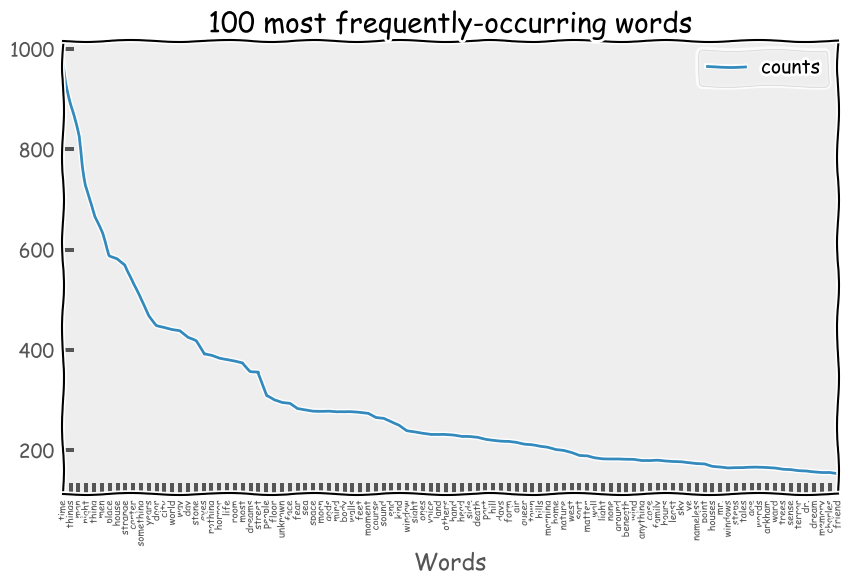

In [62]:
# Let's do some plotting
plt.clf()
fig, ax = plt.subplots(
    1,
    figsize=(10., 6.),
    dpi=100,
)
plt.xkcd()
df.plot(
    title="100 most frequently-occurring words",
    ax=ax,
)

# these commands customise our plot to make it a little more readable
ax.set_xlabel("Words")
ax.tick_params(axis='x', which='both', top='off', labelsize=7)
ax.set_xticks(xrange(100))
ax.set_xticklabels(df['items'], rotation='vertical')
ax.tick_params(axis='x', which='major', pad=5)
ax.autoscale_view(tight=None, scalex=True, scaley=False)

plt.savefig('fhtagn.png', dpi=100, alpha=True)
plt.show()